# Paleo-Detector Analysis Pipeline

This notebook provides a complete, end-to-end workflow for the phenomenological analysis of paleo-detectors. It is designed to calculate the expected nuclear recoil track spectra from both external cosmic ray muon signals and various internal/atmospheric backgrounds.

The pipeline is built around the *mineral_utils.py* module, which contains the *Paleodetector* class. This class acts as the physics engine, handling all low-level data processing and calculations. The notebook serves as a high-level interface to configure and orchestrate the analysis.

### Workflow Overview:

**1. Configuration:** All analysis parameters are defined in the configuration cells. This includes selecting the mineral from a library, defining the geological history of the sample (age, exposure time, deposition rate), and setting up the astrophysical scenarios for the cosmic ray flux.

**2. Initialization:** A Paleodetector object is created. This object automatically loads and caches all necessary input data, such as SRIM tables for ion ranges and pre-computed Geant4 results for muon interactions.

**3. Background Calculation:** The notebook calculates the track spectra for the primary background sources:

- Spontaneous Fission: Tracks from the spontaneous fission of Uranium-238 impurities within the mineral.

- Radiogenic Neutrons: Tracks from neutrons produced by (α,n) reactions in the surrounding rock.

- Neutrinos: Tracks from coherent elastic neutrino-nucleus scattering.

**7. Signal Calculation:** For each defined astrophysical scenario, the notebook calculates the track spectrum from cosmic ray muons. This core step includes a sophisticated model for a time-variant cosmic ray flux and the continuous deposition of overburden, which attenuates the signal over the exposure window. The time integration is performed in parallel for efficiency.

**8. Analysis & Plotting:** The final signal and background components are combined to produce the summary plots, showing the total expected number of tracks as a function of track length.


In [1]:
import yaml
import numpy as np
from matplotlib import pyplot as plt

# --- Custom Utility Module ---
from mineral_utils import Paleodetector

print("Libraries imported successfully.")

Libraries imported successfully.


In [2]:
mineral_name =  "Olivine"  # Must match a key in MINERAL_LIBRARY

sample_mass_kg = 0.000002       # Sample mass in kg (e.g., 0.01 for 10g)

x_bins = np.linspace(0, 50000, 100)        #Track length bins in nm
x_mids = x_bins[:-1] + np.diff(x_bins) / 2

In [3]:
CONFIG = yaml.safe_load(open('Data/basic_config.yaml', 'r'))
MINERAL_LIBRARY = yaml.safe_load(open('Data/mineral_library.yaml', 'r'))

In [4]:
exposure_times = np.array([41.4, 30., 13.1, 10.96, 9.5, 8.64, 7.65])
exposure_times_err = np.array([1., 2., 0.7, 0.15, 0.5, 0.06, 0.12])
names = np.array(["Laschamp", "Lemptegy", "Come", "Dome", "Pariou", "La Vache", "Montcineyre"], dtype=str)
energies = np.array(CONFIG['geant4_energy_bins_gev'])[:90]

In [5]:
scenario_config_simple = {
    'name': 'simple',
    'event_fluxes': {
        0.: ('H3a', 'H3a'),
        40.: ('H3a', 'H3a'),
    }
}

scenario_config_simple_enhanced = {
    'name': 'simple_enhanced',
    'event_fluxes': {
        0.: ('H3a_enhanced', 'H3a_enhanced'),
        1.4: ('H3a_enhanced', 'H3a_enhanced'),
        6.4: ('H3a', 'H3a'),
        41.4: ('H3a', 'H3a'),
    }
}

scenario_config_SN250_enhanced = {
    'name': 'SN250_enhanced',
 'event_fluxes': {1.4: ('SN250pc_7kyr_enhanced', 'SN250pc_7kyr_enhanced'),
  3.9: ('SN250pc_10kyr_enhanced', 'SN250pc_10kyr_enhanced'),
  6.4: ('SN250pc_12kyr', 'SN250pc_12kyr'),
  8.9: ('SN250pc_15kyr', 'SN250pc_15kyr'),
  11.4: ('SN250pc_17kyr', 'SN250pc_17kyr'),
  13.9: ('SN250pc_20kyr', 'SN250pc_20kyr'),
  16.4: ('SN250pc_22kyr', 'SN250pc_22kyr'),
  18.9: ('SN250pc_25kyr', 'SN250pc_25kyr'),
  21.4: ('SN250pc_27kyr', 'SN250pc_27kyr'),
  23.9: ('SN250pc_30kyr', 'SN250pc_30kyr'),
  26.4: ('SN250pc_32kyr', 'SN250pc_32kyr'),
  28.9: ('SN250pc_35kyr', 'SN250pc_35kyr'),
  31.4: ('SN250pc_37kyr', 'SN250pc_37kyr'),
  33.9: ('SN250pc_40kyr', 'SN250pc_40kyr'),
  36.4: ('SN250pc_42kyr', 'SN250pc_42kyr'),
  38.9: ('SN250pc_45kyr', 'SN250pc_45kyr'),
  41.4: ('SN250pc_47kyr', 'SN250pc_47kyr')}
}

keeys = np.linspace(0, np.floor(exposure_times[0]/2.5)*2.5, int(np.round(exposure_times[0]/2.5)))
vaals = np.floor(7.5 + np.linspace(0, np.floor(exposure_times[0]/2.5)*2.5, int(np.round(exposure_times[0]/2.5))))
scenario_config_SN250 = []
for i in range(len(exposure_times)):
    keys = np.round(keeys[keeys<exposure_times[i]]+(exposure_times[i]%2.5), 2)
    values = [(f'SN250pc_{int(val)}kyr', f'SN250pc_{int(val)}kyr') for val in vaals[-len(keeys[keeys<exposure_times[i]]):]]

    d = dict(zip(keys, values))
    dd = {'name':f'SN250_{exposure_times[i]}', 'event_fluxes':d}
    scenario_config_SN250.append(dd)

In [6]:
# --- Setup & Verification ---
mineral_config = MINERAL_LIBRARY.get(mineral_name)
if not mineral_config:
    raise ValueError(f"Mineral '{mineral_name}' not found in MINERAL_LIBRARY.")

mineral = Paleodetector(mineral_config)

Initialized Paleodetector: Olivine


In [7]:
total_fission_tracks = np.array([mineral.integrate_fission_spectrum(x_bins, age, sample_mass_kg) for age in exposure_times])

Calculating spontaneous fission background...
Calculating spontaneous fission background...
Calculating spontaneous fission background...
Calculating spontaneous fission background...
Calculating spontaneous fission background...
Calculating spontaneous fission background...
Calculating spontaneous fission background...


In [8]:
total_r_neutron_tracks = np.array([mineral.integrate_background_neutron_spectrum(x_bins, energies, age, sample_mass_kg) for age in exposure_times])

/home/cgalelli/Documents/PrimusCode/mineral_utils.py:581: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  total_tracks = [quad(total_tracks_interp, x_bins[i], x_bins[i+1])[0] for i in range(len(x_mids))]


In [9]:
total_cosmo_tracks_simple = [mineral.integrate_all_particles(x_bins, scenario_config=scenario_config_simple, energy_bins_gev=energies, exposure_window_kyr=age, initial_depth=0.05, sample_mass_kg = sample_mass_kg, steps=3) for age in exposure_times]

Processing species: mu-
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2


  0%|          | 0/4 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Olivine/mu-/simple_41.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/simple_0.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/simple_28.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/simple_14.0kyr_0.1mwe.npz


100%|██████████| 4/4 [02:24<00:00, 36.14s/it] 

Processing species: mu+
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2



  0%|          | 0/4 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Olivine/mu+/simple_14.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/simple_0.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/simple_28.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/simple_41.0kyr_0.1mwe.npz


100%|██████████| 4/4 [01:36<00:00, 24.10s/it]

Processing species: neutron
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2



  0%|          | 0/4 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Olivine/neutron/simple_14.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/simple_0.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/simple_41.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/simple_28.0kyr_0.1mwe.npz


100%|██████████| 4/4 [01:10<00:00, 17.68s/it]

Processing species: secondary_neutron
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2



  0%|          | 0/4 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/simple_0.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/simple_28.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/simple_41.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/simple_14.0kyr_0.1mwe.npz


100%|██████████| 4/4 [01:12<00:00, 18.14s/it]

Processing species: mu-
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2



  0%|          | 0/4 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Olivine/mu-/simple_10.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/simple_20.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/simple_30.0kyr_0.1mwe.npz


100%|██████████| 4/4 [01:36<00:00, 24.04s/it]

Processing species: mu+
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2



  0%|          | 0/4 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Olivine/mu+/simple_10.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/simple_30.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/simple_20.0kyr_0.1mwe.npz


100%|██████████| 4/4 [01:23<00:00, 20.93s/it]

Processing species: neutron
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2



  0%|          | 0/4 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Olivine/neutron/simple_10.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/simple_20.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/simple_30.0kyr_0.1mwe.npz


100%|██████████| 4/4 [01:11<00:00, 17.80s/it]


Processing species: secondary_neutron
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2


  0%|          | 0/4 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/simple_10.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/simple_30.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/simple_20.0kyr_0.1mwe.npz


100%|██████████| 4/4 [01:11<00:00, 17.84s/it]

Processing species: mu-
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2



  0%|          | 0/4 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Olivine/mu-/simple_9.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/simple_13.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/simple_4.0kyr_0.1mwe.npz


100%|██████████| 4/4 [01:36<00:00, 24.18s/it]


Processing species: mu+
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2


  0%|          | 0/4 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Olivine/mu+/simple_9.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/simple_13.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/simple_4.0kyr_0.1mwe.npz


100%|██████████| 4/4 [01:21<00:00, 20.49s/it]

Processing species: neutron
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2



  0%|          | 0/4 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Olivine/neutron/simple_4.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/simple_9.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/simple_13.0kyr_0.1mwe.npz


100%|██████████| 4/4 [01:03<00:00, 15.96s/it]

Processing species: secondary_neutron
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2



  0%|          | 0/4 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/simple_13.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/simple_9.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/simple_4.0kyr_0.1mwe.npz


100%|██████████| 4/4 [00:57<00:00, 14.39s/it]

Processing species: mu-
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2



  0%|          | 0/4 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Olivine/mu-/simple_7.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/simple_11.0kyr_0.1mwe.npz


100%|██████████| 4/4 [01:17<00:00, 19.49s/it]

Processing species: mu+
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2



  0%|          | 0/4 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Olivine/mu+/simple_11.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/simple_7.0kyr_0.1mwe.npz


100%|██████████| 4/4 [01:07<00:00, 16.96s/it]

Processing species: neutron
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2



  0%|          | 0/4 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Olivine/neutron/simple_11.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/simple_7.0kyr_0.1mwe.npz


100%|██████████| 4/4 [00:53<00:00, 13.38s/it]

Processing species: secondary_neutron
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2



  0%|          | 0/4 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/simple_7.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/simple_11.0kyr_0.1mwe.npz


100%|██████████| 4/4 [00:57<00:00, 14.29s/it]

Processing species: mu-
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2



  0%|          | 0/4 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Olivine/mu-/simple_3.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/simple_6.0kyr_0.1mwe.npz


100%|██████████| 4/4 [01:17<00:00, 19.38s/it]

Processing species: mu+
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2



  0%|          | 0/4 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Olivine/mu+/simple_3.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/simple_6.0kyr_0.1mwe.npz


100%|██████████| 4/4 [01:07<00:00, 16.86s/it]

Processing species: neutron
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2



  0%|          | 0/4 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Olivine/neutron/simple_3.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/simple_6.0kyr_0.1mwe.npz


100%|██████████| 4/4 [00:53<00:00, 13.36s/it]

Processing species: secondary_neutron
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2



  0%|          | 0/4 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/simple_3.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/simple_6.0kyr_0.1mwe.npz


100%|██████████| 4/4 [00:57<00:00, 14.28s/it]

Processing species: mu-
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2



100%|██████████| 4/4 [01:00<00:00, 15.09s/it]

Processing species: mu+
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2



100%|██████████| 4/4 [00:56<00:00, 14.08s/it]

Processing species: neutron
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2



100%|██████████| 4/4 [00:51<00:00, 12.92s/it]

Processing species: secondary_neutron
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2



100%|██████████| 4/4 [00:51<00:00, 12.86s/it]

Processing species: mu-
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2



  0%|          | 0/4 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Olivine/mu-/simple_8.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/simple_5.0kyr_0.1mwe.npz


100%|██████████| 4/4 [01:17<00:00, 19.45s/it]

Processing species: mu+
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2



  0%|          | 0/4 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Olivine/mu+/simple_5.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/simple_8.0kyr_0.1mwe.npz


100%|██████████| 4/4 [01:07<00:00, 16.96s/it]

Processing species: neutron
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2



  0%|          | 0/4 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Olivine/neutron/simple_5.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/simple_8.0kyr_0.1mwe.npz


100%|██████████| 4/4 [00:53<00:00, 13.40s/it]


Processing species: secondary_neutron
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2


  0%|          | 0/4 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/simple_5.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/simple_8.0kyr_0.1mwe.npz


100%|██████████| 4/4 [00:57<00:00, 14.33s/it]


In [10]:
total_cosmo_tracks_SN250 = [mineral.integrate_all_particles(x_bins, scenario_config=scenario_config_SN250[i], energy_bins_gev=energies, exposure_window_kyr=age, initial_depth=0.05, sample_mass_kg = sample_mass_kg, steps=int(age/2)) for i, age in enumerate(exposure_times)]

Processing species: mu-
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2


  0%|          | 0/21 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_41.4_4.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_41.4_2.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_41.4_0.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_41.4_8.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_41.4_10.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_41.4_6.0kyr_0.1mwe.npz


 29%|██▊       | 6/21 [01:42<02:35, 10.38s/it]

    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_41.4_14.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_41.4_12.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_41.4_17.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_41.4_21.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_41.4_23.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_41.4_19.0kyr_0.1mwe.npz


 57%|█████▋    | 12/21 [03:23<01:22,  9.21s/it]

    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_41.4_25.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_41.4_27.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_41.4_29.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_41.4_31.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_41.4_35.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_41.4_33.0kyr_0.1mwe.npz


 86%|████████▌ | 18/21 [05:03<00:20,  6.91s/it]

    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_41.4_37.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_41.4_39.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_41.4_41.0kyr_0.1mwe.npz


100%|██████████| 21/21 [06:16<00:00, 17.92s/it]

Processing species: mu+
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2



  0%|          | 0/21 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_41.4_6.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_41.4_4.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_41.4_8.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_41.4_10.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_41.4_2.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_41.4_0.0kyr_0.1mwe.npz


  5%|▍         | 1/21 [01:53<37:40, 113.02s/it]

    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_41.4_12.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_41.4_14.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_41.4_19.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_41.4_17.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_41.4_21.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_41.4_23.0kyr_0.1mwe.npz


 38%|███▊      | 8/21 [03:45<05:08, 23.71s/it] 

    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_41.4_27.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_41.4_25.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_41.4_29.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_41.4_33.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_41.4_31.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_41.4_35.0kyr_0.1mwe.npz


 76%|███████▌  | 16/21 [05:39<01:12, 14.54s/it]

    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_41.4_37.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_41.4_39.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_41.4_41.0kyr_0.1mwe.npz


100%|██████████| 21/21 [06:46<00:00, 19.35s/it]

Processing species: neutron
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2



  0%|          | 0/21 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_41.4_0.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_41.4_4.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_41.4_6.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_41.4_2.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_41.4_8.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_41.4_10.0kyr_0.1mwe.npz


  5%|▍         | 1/21 [01:08<22:56, 68.81s/it]

    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_41.4_12.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_41.4_14.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_41.4_17.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_41.4_19.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_41.4_21.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_41.4_23.0kyr_0.1mwe.npz


 33%|███▎      | 7/21 [02:15<03:59, 17.10s/it]

    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_41.4_25.0kyr_0.1mwe.npz


 57%|█████▋    | 12/21 [02:17<01:16,  8.47s/it]

    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_41.4_27.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_41.4_29.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_41.4_33.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_41.4_31.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_41.4_35.0kyr_0.1mwe.npz


 86%|████████▌ | 18/21 [03:24<00:23,  7.87s/it]

    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_41.4_37.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_41.4_39.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_41.4_41.0kyr_0.1mwe.npz


100%|██████████| 21/21 [04:13<00:00, 12.08s/it]

Processing species: secondary_neutron
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2



  0%|          | 0/21 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_41.4_0.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_41.4_4.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_41.4_6.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_41.4_2.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_41.4_10.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_41.4_8.0kyr_0.1mwe.npz


 24%|██▍       | 5/21 [01:16<03:05, 11.59s/it]

    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_41.4_12.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_41.4_14.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_41.4_17.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_41.4_19.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_41.4_21.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_41.4_23.0kyr_0.1mwe.npz


 43%|████▎     | 9/21 [02:28<02:36, 13.01s/it]

    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_41.4_25.0kyr_0.1mwe.npz


 57%|█████▋    | 12/21 [02:31<01:03,  7.05s/it]

    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_41.4_27.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_41.4_29.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_41.4_31.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_41.4_33.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_41.4_35.0kyr_0.1mwe.npz


 81%|████████  | 17/21 [03:42<00:27,  6.91s/it]

    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_41.4_37.0kyr_0.1mwe.npz


 86%|████████▌ | 18/21 [03:44<00:16,  5.65s/it]

    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_41.4_39.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_41.4_41.0kyr_0.1mwe.npz


100%|██████████| 21/21 [04:34<00:00, 13.09s/it]

Processing species: mu-
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2



  0%|          | 0/16 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_30.0_4.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_30.0_6.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_30.0_10.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_30.0_8.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_30.0_2.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_30.0_0.0kyr_0.1mwe.npz


 12%|█▎        | 2/16 [01:42<09:54, 42.47s/it] 

    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_30.0_16.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_30.0_14.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_30.0_18.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_30.0_20.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_30.0_22.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_30.0_12.0kyr_0.1mwe.npz


 69%|██████▉   | 11/16 [03:23<01:03, 12.73s/it]

    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_30.0_24.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_30.0_28.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_30.0_26.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_30.0_30.0kyr_0.1mwe.npz


100%|██████████| 16/16 [04:44<00:00, 17.78s/it]

Processing species: mu+
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2



  0%|          | 0/16 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_30.0_10.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_30.0_6.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_30.0_8.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_30.0_2.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_30.0_4.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_30.0_0.0kyr_0.1mwe.npz


  6%|▋         | 1/16 [02:04<31:06, 124.43s/it]

    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_30.0_12.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_30.0_14.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_30.0_20.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_30.0_18.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_30.0_16.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_30.0_22.0kyr_0.1mwe.npz


 62%|██████▎   | 10/16 [04:07<01:53, 18.89s/it]

    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_30.0_24.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_30.0_26.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_30.0_28.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_30.0_30.0kyr_0.1mwe.npz


100%|██████████| 16/16 [05:15<00:00, 19.70s/it]

Processing species: neutron
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2



  0%|          | 0/16 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_30.0_0.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_30.0_2.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_30.0_8.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_30.0_6.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_30.0_10.0kyr_0.1mwe.npz    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_30.0_4.0kyr_0.1mwe.npz



 25%|██▌       | 4/16 [01:13<02:20, 11.68s/it]

    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_30.0_12.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_30.0_16.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_30.0_18.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_30.0_20.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_30.0_14.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_30.0_22.0kyr_0.1mwe.npz


 50%|█████     | 8/16 [02:24<01:57, 14.70s/it]

    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_30.0_24.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_30.0_26.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_30.0_28.0kyr_0.1mwe.npz


 75%|███████▌  | 12/16 [02:25<00:27,  6.85s/it]

    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_30.0_30.0kyr_0.1mwe.npz


100%|██████████| 16/16 [03:19<00:00, 12.44s/it]

Processing species: secondary_neutron
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2



  0%|          | 0/16 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_30.0_0.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_30.0_6.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_30.0_4.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_30.0_10.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_30.0_2.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_30.0_8.0kyr_0.1mwe.npz


 19%|█▉        | 3/16 [01:17<03:49, 17.62s/it]

    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_30.0_14.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_30.0_12.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_30.0_16.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_30.0_20.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_30.0_18.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_30.0_22.0kyr_0.1mwe.npz


 62%|██████▎   | 10/16 [02:30<01:00, 10.16s/it]

    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_30.0_24.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_30.0_26.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_30.0_28.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_30.0_30.0kyr_0.1mwe.npz


100%|██████████| 16/16 [03:28<00:00, 13.02s/it]

Processing species: mu-
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2



  0%|          | 0/7 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_13.1_0.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_13.1_2.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_13.1_7.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_13.1_4.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_13.1_9.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_13.1_11.0kyr_0.1mwe.npz


 86%|████████▌ | 6/7 [01:43<00:09,  9.15s/it] 

    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_13.1_13.0kyr_0.1mwe.npz


100%|██████████| 7/7 [02:50<00:00, 24.31s/it]

Processing species: mu+
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2



  0%|          | 0/7 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_13.1_4.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_13.1_7.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_13.1_2.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_13.1_0.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_13.1_11.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_13.1_9.0kyr_0.1mwe.npz


 29%|██▊       | 2/7 [01:29<03:05, 37.05s/it]

    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_13.1_13.0kyr_0.1mwe.npz


100%|██████████| 7/7 [02:28<00:00, 21.27s/it]

Processing species: neutron
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2



  0%|          | 0/7 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_13.1_0.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_13.1_2.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_13.1_7.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_13.1_11.0kyr_0.1mwe.npz    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_13.1_4.0kyr_0.1mwe.npz

    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_13.1_9.0kyr_0.1mwe.npz


 43%|████▎     | 3/7 [01:09<01:12, 18.13s/it]

    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_13.1_13.0kyr_0.1mwe.npz


100%|██████████| 7/7 [01:53<00:00, 16.21s/it]

Processing species: secondary_neutron
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2



  0%|          | 0/7 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_13.1_4.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_13.1_7.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_13.1_0.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_13.1_2.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_13.1_11.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_13.1_9.0kyr_0.1mwe.npz


 86%|████████▌ | 6/7 [01:14<00:07,  7.53s/it]

    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_13.1_13.0kyr_0.1mwe.npz


100%|██████████| 7/7 [02:02<00:00, 17.45s/it]

Processing species: mu-
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2



  0%|          | 0/6 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_10.96_2.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_10.96_0.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_10.96_7.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_10.96_9.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_10.96_11.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_10.96_4.0kyr_0.1mwe.npz


100%|██████████| 6/6 [01:42<00:00, 17.09s/it]

Processing species: mu+
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2



  0%|          | 0/6 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_10.96_7.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_10.96_11.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_10.96_0.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_10.96_4.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_10.96_9.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_10.96_2.0kyr_0.1mwe.npz


100%|██████████| 6/6 [01:29<00:00, 14.92s/it]

Processing species: neutron
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2



  0%|          | 0/6 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_10.96_2.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_10.96_7.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_10.96_0.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_10.96_11.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_10.96_4.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_10.96_9.0kyr_0.1mwe.npz


100%|██████████| 6/6 [01:09<00:00, 11.57s/it]

Processing species: secondary_neutron
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2



  0%|          | 0/6 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_10.96_7.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_10.96_2.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_10.96_9.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_10.96_4.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_10.96_11.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_10.96_0.0kyr_0.1mwe.npz


100%|██████████| 6/6 [01:15<00:00, 12.50s/it]

Processing species: mu-
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2



  0%|          | 0/5 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_9.5_0.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_9.5_5.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_9.5_10.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_9.5_7.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_9.5_2.0kyr_0.1mwe.npz


100%|██████████| 5/5 [01:27<00:00, 17.53s/it]

Processing species: mu+
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2



  0%|          | 0/5 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_9.5_7.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_9.5_0.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_9.5_2.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_9.5_10.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_9.5_5.0kyr_0.1mwe.npz


100%|██████████| 5/5 [01:16<00:00, 15.28s/it]

Processing species: neutron
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2



  0%|          | 0/5 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_9.5_0.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_9.5_2.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_9.5_5.0kyr_0.1mwe.npz    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_9.5_10.0kyr_0.1mwe.npz

    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_9.5_7.0kyr_0.1mwe.npz


100%|██████████| 5/5 [01:00<00:00, 12.04s/it]


Processing species: secondary_neutron
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2


  0%|          | 0/5 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_9.5_2.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_9.5_0.0kyr_0.1mwe.npz    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_9.5_10.0kyr_0.1mwe.npz

    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_9.5_7.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_9.5_5.0kyr_0.1mwe.npz


100%|██████████| 5/5 [01:03<00:00, 12.72s/it]

Processing species: mu-
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2



  0%|          | 0/5 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_8.64_0.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_8.64_2.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_8.64_6.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_8.64_4.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_8.64_9.0kyr_0.1mwe.npz


100%|██████████| 5/5 [01:27<00:00, 17.49s/it]

Processing species: mu+
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2



  0%|          | 0/5 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_8.64_6.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_8.64_0.0kyr_0.1mwe.npz    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_8.64_4.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_8.64_9.0kyr_0.1mwe.npz

    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_8.64_2.0kyr_0.1mwe.npz


100%|██████████| 5/5 [01:16<00:00, 15.23s/it]

Processing species: neutron
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2



  0%|          | 0/5 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_8.64_0.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_8.64_2.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_8.64_4.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_8.64_9.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_8.64_6.0kyr_0.1mwe.npz


100%|██████████| 5/5 [00:58<00:00, 11.77s/it]

Processing species: secondary_neutron
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2



  0%|          | 0/5 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_8.64_0.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_8.64_4.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_8.64_2.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_8.64_9.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_8.64_6.0kyr_0.1mwe.npz


100%|██████████| 5/5 [01:03<00:00, 12.73s/it]

Processing species: mu-
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2



  0%|          | 0/4 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_7.65_0.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_7.65_5.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_7.65_8.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_7.65_3.0kyr_0.1mwe.npz


100%|██████████| 4/4 [01:21<00:00, 20.32s/it]

Processing species: mu+
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2



  0%|          | 0/4 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_7.65_5.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_7.65_3.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_7.65_0.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_7.65_8.0kyr_0.1mwe.npz


100%|██████████| 4/4 [01:10<00:00, 17.71s/it]

Processing species: neutron
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2



  0%|          | 0/4 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_7.65_0.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_7.65_3.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_7.65_5.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_7.65_8.0kyr_0.1mwe.npz


100%|██████████| 4/4 [00:54<00:00, 13.67s/it]

Processing species: secondary_neutron
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2



  0%|          | 0/4 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_7.65_0.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_7.65_3.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_7.65_5.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_7.65_8.0kyr_0.1mwe.npz


100%|██████████| 4/4 [00:59<00:00, 14.90s/it]


In [11]:
tracks_enhanced_simple = mineral.integrate_all_particles(x_bins, scenario_config=scenario_config_simple_enhanced, energy_bins_gev=energies, exposure_window_kyr=exposure_times[0], initial_depth=0.05, sample_mass_kg = sample_mass_kg, steps=20)
tracks_enhanced_SN250 = mineral.integrate_all_particles(x_bins, scenario_config=scenario_config_SN250_enhanced, energy_bins_gev=energies, exposure_window_kyr=exposure_times[0], initial_depth=0.05, sample_mass_kg = sample_mass_kg, steps=20)

Processing species: mu-
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2


  0%|          | 0/21 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Olivine/mu-/simple_enhanced_10.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/simple_enhanced_4.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/simple_enhanced_0.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/simple_enhanced_6.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/simple_enhanced_8.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/simple_enhanced_2.0kyr_0.1mwe.npz


 24%|██▍       | 5/21 [01:40<03:41, 13.85s/it]

    - Saved processed data to Data/processed_recoils/Olivine/mu-/simple_enhanced_12.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/simple_enhanced_14.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/simple_enhanced_17.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/simple_enhanced_21.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/simple_enhanced_19.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/simple_enhanced_23.0kyr_0.1mwe.npz


 38%|███▊      | 8/21 [03:20<04:57, 22.86s/it]

    - Saved processed data to Data/processed_recoils/Olivine/mu-/simple_enhanced_25.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/simple_enhanced_29.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/simple_enhanced_31.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/simple_enhanced_27.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/simple_enhanced_33.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/simple_enhanced_35.0kyr_0.1mwe.npz


 67%|██████▋   | 14/21 [05:00<02:05, 17.93s/it]

    - Saved processed data to Data/processed_recoils/Olivine/mu-/simple_enhanced_39.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/simple_enhanced_37.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/simple_enhanced_41.0kyr_0.1mwe.npz


100%|██████████| 21/21 [06:15<00:00, 17.87s/it]

Processing species: mu+
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2



  0%|          | 0/21 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Olivine/mu+/simple_enhanced_0.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/simple_enhanced_4.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/simple_enhanced_10.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/simple_enhanced_6.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/simple_enhanced_2.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/simple_enhanced_8.0kyr_0.1mwe.npz


 10%|▉         | 2/21 [01:27<11:34, 36.57s/it]

    - Saved processed data to Data/processed_recoils/Olivine/mu+/simple_enhanced_12.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/simple_enhanced_14.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/simple_enhanced_17.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/simple_enhanced_19.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/simple_enhanced_21.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/simple_enhanced_23.0kyr_0.1mwe.npz


 57%|█████▋    | 12/21 [02:55<01:09,  7.69s/it]

    - Saved processed data to Data/processed_recoils/Olivine/mu+/simple_enhanced_25.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/simple_enhanced_27.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/simple_enhanced_29.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/simple_enhanced_31.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/simple_enhanced_33.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/simple_enhanced_35.0kyr_0.1mwe.npz


 86%|████████▌ | 18/21 [04:22<00:25,  8.59s/it]

    - Saved processed data to Data/processed_recoils/Olivine/mu+/simple_enhanced_37.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/simple_enhanced_41.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/simple_enhanced_39.0kyr_0.1mwe.npz


100%|██████████| 21/21 [05:25<00:00, 15.50s/it]

Processing species: neutron
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2



  0%|          | 0/21 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Olivine/neutron/simple_enhanced_2.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/simple_enhanced_4.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/simple_enhanced_0.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/simple_enhanced_10.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/simple_enhanced_6.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/simple_enhanced_8.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/simple_enhanced_12.0kyr_0.1mwe.npz


  5%|▍         | 1/21 [01:08<22:46, 68.30s/it]

    - Saved processed data to Data/processed_recoils/Olivine/neutron/simple_enhanced_17.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/simple_enhanced_14.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/simple_enhanced_19.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/simple_enhanced_21.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/simple_enhanced_23.0kyr_0.1mwe.npz


 52%|█████▏    | 11/21 [02:15<01:21,  8.15s/it]

    - Saved processed data to Data/processed_recoils/Olivine/neutron/simple_enhanced_25.0kyr_0.1mwe.npz


 57%|█████▋    | 12/21 [02:15<01:02,  6.89s/it]

    - Saved processed data to Data/processed_recoils/Olivine/neutron/simple_enhanced_27.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/simple_enhanced_29.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/simple_enhanced_31.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/simple_enhanced_33.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/simple_enhanced_35.0kyr_0.1mwe.npz


 86%|████████▌ | 18/21 [03:22<00:18,  6.26s/it]

    - Saved processed data to Data/processed_recoils/Olivine/neutron/simple_enhanced_37.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/simple_enhanced_39.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/simple_enhanced_41.0kyr_0.1mwe.npz


100%|██████████| 21/21 [04:11<00:00, 11.99s/it]

Processing species: secondary_neutron
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2



  0%|          | 0/21 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/simple_enhanced_2.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/simple_enhanced_0.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/simple_enhanced_4.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/simple_enhanced_6.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/simple_enhanced_10.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/simple_enhanced_8.0kyr_0.1mwe.npz


 24%|██▍       | 5/21 [01:13<02:40, 10.06s/it]

    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/simple_enhanced_12.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/simple_enhanced_14.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/simple_enhanced_17.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/simple_enhanced_21.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/simple_enhanced_23.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/simple_enhanced_19.0kyr_0.1mwe.npz


 57%|█████▋    | 12/21 [02:26<01:16,  8.54s/it]

    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/simple_enhanced_25.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/simple_enhanced_27.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/simple_enhanced_29.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/simple_enhanced_31.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/simple_enhanced_33.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/simple_enhanced_35.0kyr_0.1mwe.npz


 86%|████████▌ | 18/21 [03:38<00:20,  6.80s/it]

    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/simple_enhanced_37.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/simple_enhanced_39.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/simple_enhanced_41.0kyr_0.1mwe.npz


100%|██████████| 21/21 [04:32<00:00, 12.96s/it]

Processing species: mu-
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2



  0%|          | 0/21 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_enhanced_4.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_enhanced_6.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_enhanced_2.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_enhanced_0.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_enhanced_8.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_enhanced_10.0kyr_0.1mwe.npz


 10%|▉         | 2/21 [01:40<13:08, 41.51s/it] 

    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_enhanced_14.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_enhanced_12.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_enhanced_17.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_enhanced_19.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_enhanced_23.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_enhanced_21.0kyr_0.1mwe.npz


 48%|████▊     | 10/21 [03:21<02:32, 13.83s/it]

    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_enhanced_25.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_enhanced_27.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_enhanced_29.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_enhanced_33.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_enhanced_35.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_enhanced_31.0kyr_0.1mwe.npz


 76%|███████▌  | 16/21 [05:02<01:06, 13.37s/it]

    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_enhanced_37.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_enhanced_39.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu-/SN250_enhanced_41.0kyr_0.1mwe.npz


100%|██████████| 21/21 [06:14<00:00, 17.84s/it]

Processing species: mu+
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2



  0%|          | 0/21 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_enhanced_4.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_enhanced_8.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_enhanced_10.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_enhanced_0.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_enhanced_6.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_enhanced_2.0kyr_0.1mwe.npz


 29%|██▊       | 6/21 [01:27<02:42, 10.82s/it]

    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_enhanced_17.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_enhanced_14.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_enhanced_12.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_enhanced_21.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_enhanced_19.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_enhanced_23.0kyr_0.1mwe.npz


 57%|█████▋    | 12/21 [02:54<01:09,  7.69s/it]

    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_enhanced_25.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_enhanced_29.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_enhanced_31.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_enhanced_33.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_enhanced_27.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_enhanced_35.0kyr_0.1mwe.npz


 86%|████████▌ | 18/21 [04:22<00:24,  8.21s/it]

    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_enhanced_37.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_enhanced_39.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/mu+/SN250_enhanced_41.0kyr_0.1mwe.npz


100%|██████████| 21/21 [05:26<00:00, 15.55s/it]

Processing species: neutron
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2



  0%|          | 0/21 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_enhanced_0.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_enhanced_4.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_enhanced_6.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_enhanced_2.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_enhanced_8.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_enhanced_10.0kyr_0.1mwe.npz


 24%|██▍       | 5/21 [01:08<02:31,  9.50s/it]

    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_enhanced_12.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_enhanced_14.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_enhanced_17.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_enhanced_19.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_enhanced_21.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_enhanced_23.0kyr_0.1mwe.npz


 57%|█████▋    | 12/21 [02:16<01:04,  7.21s/it]

    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_enhanced_25.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_enhanced_27.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_enhanced_29.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_enhanced_31.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_enhanced_33.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_enhanced_35.0kyr_0.1mwe.npz


 62%|██████▏   | 13/21 [03:20<02:21, 17.68s/it]

    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_enhanced_37.0kyr_0.1mwe.npz


 67%|██████▋   | 14/21 [03:23<01:42, 14.64s/it]

    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_enhanced_39.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/neutron/SN250_enhanced_41.0kyr_0.1mwe.npz


100%|██████████| 21/21 [04:12<00:00, 12.03s/it]

Processing species: secondary_neutron
Integrating the signal in a 0.001 mm slice of Olivine with mass 0.002 g, corresponding to 5.263157894736842 cm2



  0%|          | 0/21 [00:00<?, ?it/s]

    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_enhanced_4.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_enhanced_0.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_enhanced_2.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_enhanced_6.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_enhanced_8.0kyr_0.1mwe.npz    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_enhanced_10.0kyr_0.1mwe.npz



  5%|▍         | 1/21 [01:13<24:34, 73.70s/it]

    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_enhanced_14.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_enhanced_12.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_enhanced_17.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_enhanced_19.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_enhanced_21.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_enhanced_23.0kyr_0.1mwe.npz


 52%|█████▏    | 11/21 [02:25<01:23,  8.34s/it]

    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_enhanced_25.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_enhanced_27.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_enhanced_29.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_enhanced_31.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_enhanced_33.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_enhanced_35.0kyr_0.1mwe.npz


 86%|████████▌ | 18/21 [03:39<00:15,  5.14s/it]

    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_enhanced_37.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_enhanced_39.0kyr_0.1mwe.npz
    - Saved processed data to Data/processed_recoils/Olivine/secondary_neutron/SN250_enhanced_41.0kyr_0.1mwe.npz


100%|██████████| 21/21 [04:31<00:00, 12.94s/it]


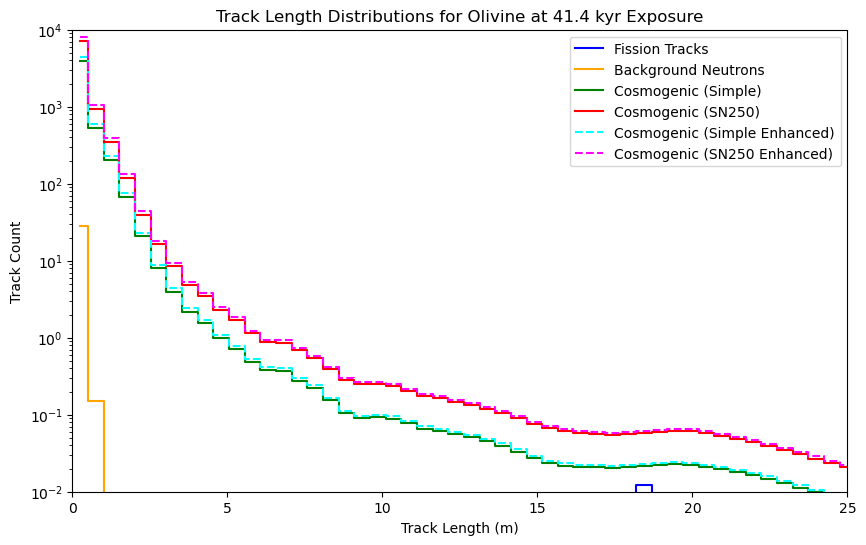

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.step(x_mids/1000., total_fission_tracks[0], label='Fission Tracks', color='blue', where='mid')
ax.step(x_mids/1000., total_r_neutron_tracks[0], label='Background Neutrons', color='orange', where='mid')
ax.step(x_mids/1000., total_cosmo_tracks_simple[0]['total'], label='Cosmogenic (Simple)', color='green', where='mid')
ax.step(x_mids/1000., total_cosmo_tracks_SN250[0]['total'], label='Cosmogenic (SN250)', color='red', where='mid')
ax.step(x_mids/1000., tracks_enhanced_simple['total'], label='Cosmogenic (Simple Enhanced)', color='cyan', linestyle='--', where='mid')
ax.step(x_mids/1000., tracks_enhanced_SN250['total'], label='Cosmogenic (SN250 Enhanced)', color='magenta', linestyle='--', where='mid')

ax.set_yscale('log')
ax.set_xlim(0, 25.)
ax.set_ylim(1e-2, 1e4)
ax.set_xlabel(r'Track Length (m)')
ax.set_ylabel('Track Count')
ax.set_title(f'Track Length Distributions for {mineral_name} at 41.4 kyr Exposure')
ax.legend()
plt.show()